Imports and model name

In [1]:
from transformers import AutoTokenizer

gpt2_model_id = "gpt2"
bert_model_id = "prajjwal1/bert-small"

e:\Downloads\Programs\conda\envs\GuidedNeuralChecker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining tokenizers

In [2]:
gpt2_tokenizer_w_ps = AutoTokenizer.from_pretrained(gpt2_model_id, use_fast=True, add_prefix_space=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_id, use_fast=True, add_prefix_space=False)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_id, use_fast=True, add_prefix_space=False)

Create Guide Models

In [3]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_small_man_woman_wfa
from pythautomata.base_types.symbol import SymbolStr

gpt2_property_model = get_small_man_woman_wfa(SymbolStr(gpt2_tokenizer.eos_token))
bert_property_model = get_small_man_woman_wfa(SymbolStr(bert_tokenizer.sep_token))

Load GPT-2 Model

In [4]:
import torch
from transformers import AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=gpt2_tokenizer.eos_token_id).to(device)
bert_model = AutoModelForCausalLM.from_pretrained(bert_model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=bert_tokenizer.sep_token_id).to(device)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [5]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from case_studies.bert_small.bert_small_probabilistic_model_wrapper import BERT_SMALL_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import small_alphabet as alphabet

gpt2_wrapper_w_ps = GPT2_probabilistic_model_wrapper(50, alphabet, device, gpt2_model, gpt2_tokenizer_w_ps)
gpt2_wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, gpt2_model, gpt2_tokenizer)
bert_wrapper = BERT_SMALL_probabilistic_model_wrapper(50, alphabet, device, bert_model, bert_tokenizer)

In [6]:
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
gpt2_guiding_generator = GuidingWDFASequenceGenerator(gpt2_property_model, None)
bert_guiding_generator = GuidingWDFASequenceGenerator(bert_property_model, None)

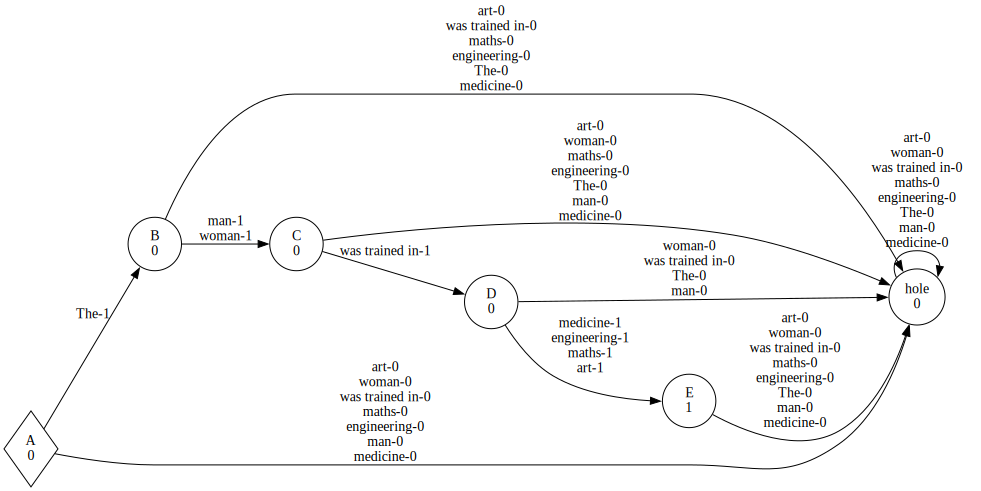

In [7]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(gpt2_property_model)

display(graph)

In [8]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel

gpt2_syncrhronic_model_w_ps = SyncronicModelGuidedLanguageModel(gpt2_wrapper_w_ps, gpt2_property_model, model_name="GUIDED_GPT2_WITH_PREFIX_SPACE", max_seq_length=10, normalize_outputs=True, top_k=3)
gpt2_syncrhronic_model = SyncronicModelGuidedLanguageModel(gpt2_wrapper, gpt2_property_model, model_name="GUIDED_GPT2", max_seq_length=10, normalize_outputs=True, top_k=3)
bert_syncrhronic_model = SyncronicModelGuidedLanguageModel(bert_wrapper, bert_property_model, model_name="GUIDED_BERT_SMALL", max_seq_length=10, normalize_outputs=True, top_k=3)

In [9]:
from utilities.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import QuantizationProbabilityPartitionerPlus
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
partitioner = QuantizationProbabilityPartitionerPlus(1000)
comparator = WFAPartitionComparator(partitioner)
max_states = 50
max_query_length = 50


In [10]:
gpt2_teacher_w_ps = HypothesisAwareSampleProbabilisticTeacher(gpt2_syncrhronic_model_w_ps, comparator, 30)
gpt2_teacher = HypothesisAwareSampleProbabilisticTeacher(gpt2_syncrhronic_model, comparator, 30)
bert_teacher = HypothesisAwareSampleProbabilisticTeacher(bert_syncrhronic_model, comparator, 30)

In [11]:
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False, omit_zero_transitions=True)

In [12]:
gpt2_w_ps_learning_result = learner.learn(gpt2_teacher_w_ps, verbose=False)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [13]:
gpt2_learning_result = learner.learn(gpt2_teacher, verbose=False)

In [14]:
bert_learning_result = learner.learn(bert_teacher, verbose=False)

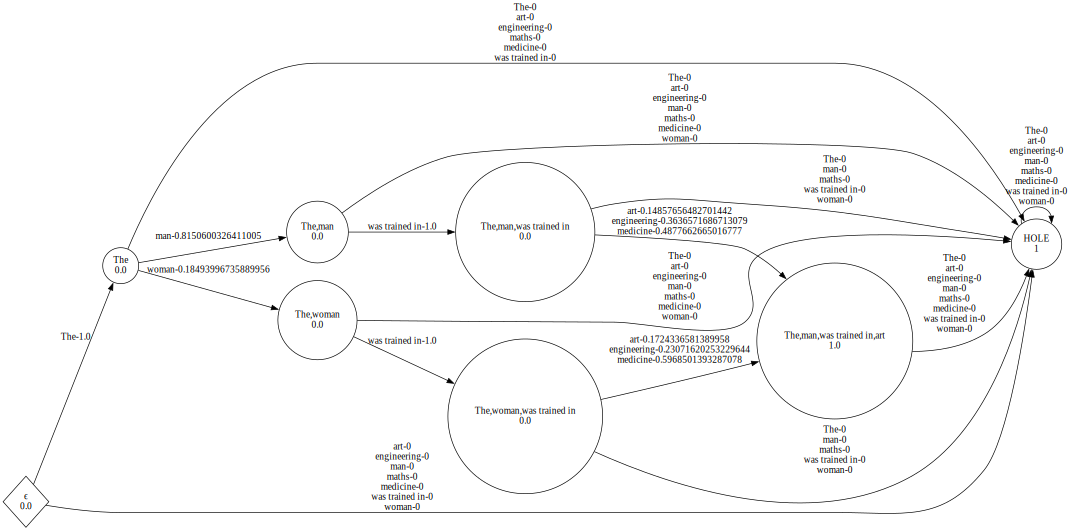

In [15]:
display(exporter.create_graph(gpt2_w_ps_learning_result.model))

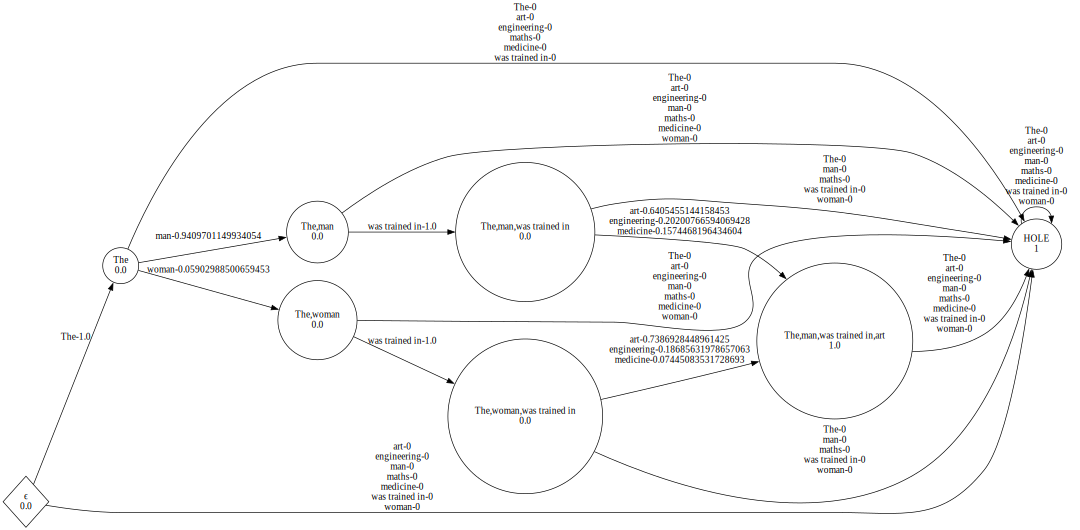

In [16]:
display(exporter.create_graph(gpt2_learning_result.model))

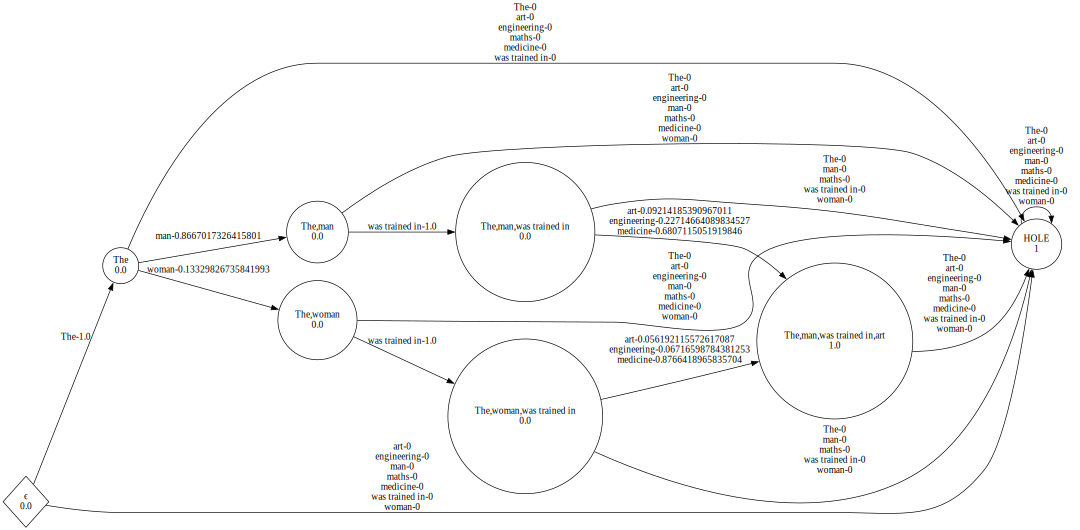

In [17]:
display(exporter.create_graph(bert_learning_result.model))